In [442]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import warnings
warnings.filterwarnings("ignore")
import pickle
import wordcloud 
import spacy
import spacy.lang.pt
import string

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from unicodedata import normalize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from collections import Counter
from sklearn.metrics import classification_report,confusion_matrix

In [303]:
#pip install openpyxl
#!pip install nltk
#!pip install spacy

#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')
#nltk.download('omw-1.4')

In [304]:
df = pd.read_excel("C:\\Users\\Thiag\\spam_ham\\data\\processed\\Data_Train_utf.xlsx")
df.head()

,ID,Message,SPAM
0,615317,Linda msg!,True
1,855344,To fazendo batida de kwui com coco,True
2,1007222,Esse dinheiro só vai sair para quem está com o...,True
3,811063,Isso msm Irmã.. nao lembrava dos nomes kkk,True
4,913944,Ai xara eu sujiro esse,True


In [305]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1773 entries, 0 to 1772
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ID       1773 non-null   int64 
 1   Message  1773 non-null   object
 2   SPAM     1773 non-null   bool  
dtypes: bool(1), int64(1), object(1)
memory usage: 29.6+ KB


In [306]:
df.shape

(1773, 3)

In [307]:
df.drop_duplicates(inplace=True)

In [308]:
df.isnull().sum()

ID         0
Message    0
SPAM       0
dtype: int64

In [309]:
data = df.copy()
data.head()

,ID,Message,SPAM
0,615317,Linda msg!,True
1,855344,To fazendo batida de kwui com coco,True
2,1007222,Esse dinheiro só vai sair para quem está com o...,True
3,811063,Isso msm Irmã.. nao lembrava dos nomes kkk,True
4,913944,Ai xara eu sujiro esse,True


In [310]:
df.SPAM.value_counts()

True     932
False    841
Name: SPAM, dtype: int64

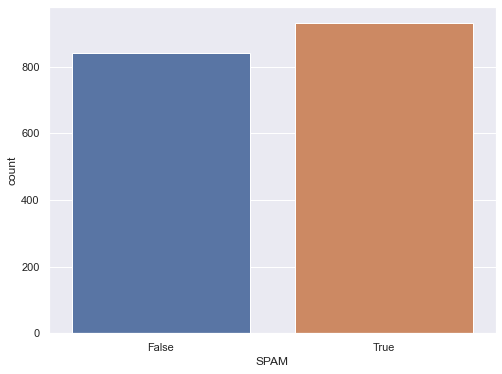

In [311]:
sns.countplot(df['SPAM'])
plt.show()

The plot show that the dataset is balanced

A essential step before model training is convert 'SPAM' to numeric form, because deep learning models need data in numeric form.

In [312]:
df['Spam'] = df['SPAM'].map({True:1, False:0}) #Dúvida, substitui bool por int. *Pode? Faz diferença na modelagem?

In [365]:
df

,ID,Message,SPAM,Spam,text_norm,text_tokenized,text_lemmatized,Message_len,punct%
0,615317,Linda msg!,True,1,linda msg,"[linda, msg]","[linda, msg]",9,11.1
1,855344,To fazendo batida de kwui com coco,True,1,fazendo batida kwui coco,"[fazendo, batida, kwui, coco]","[fazendo, batida, kwui, coco]",28,0.0
2,1007222,Esse dinheiro só vai sair para quem está com o...,True,1,esse dinheiro sair nome lista esse dinheiro sa...,"[esse, dinheiro, sair, nome, lista, esse, dinh...","[esse, dinheiro, sair, nome, lista, esse, dinh...",113,7.1
3,811063,Isso msm Irmã.. nao lembrava dos nomes kkk,True,1,isso msm irma lembrava nomes kkk,"[isso, msm, irma, lembrava, nomes, kkk]","[isso, msm, irma, lembrava, nome, kkk]",35,5.7
4,913944,Ai xara eu sujiro esse,True,1,xara sujiro,"[xara, sujiro]","[xara, sujiro]",18,0.0
...,...,...,...,...,...,...,...,...,...
1768,521420,Meu nome e alex sandro,True,1,meu nome alex sandro,"[meu, nome, alex, sandro]","[meu, nome, alex, sandro]",18,0.0
1769,791210,Hum\nTenho ums aki\nN\nTenhos ums piso aki\nE ...,True,1,hum tenho ums aki tenhos ums piso aki divisoria,"[hum, tenho, ums, aki, tenhos, ums, piso, aki,...","[hum, tenho, ums, aki, tenhos, ums, piso, aki,...",45,0.0
1770,1031770,Quem tem padrinho não morre pagão\nQuem tem pa...,True,1,quem padrinho morre pagao quem padrinho morre ...,"[quem, padrinho, morre, pagao, quem, padrinho,...","[quem, padrinho, morre, pagao, quem, padrinho,...",81,0.0
1771,580122,ALUNO QUE PROCESSOU PROFESSOR POR TER TOMADO C...,True,1,aluno que processou professor por ter tomado c...,"[aluno, que, processou, professor, por, ter, t...","[aluno, que, processou, professor, por, ter, t...",2302,4.0


## Making a word cloud

In [315]:
nltk_stopwords = stopwords.words('portuguese') + ["da", "meu", "em", "de", "ao", "os", "para", "vai", "pra"]
#stopwords.update(["da", "meu", "em", "você", "de", "ao", "os", "bom", "para", "vai", "pra", "nao"])

In [ ]:
nltk_stopwords 

In [317]:
def remove_stopwords(texto):
    
    novo_texto = []
    tokens = nltk.word_tokenize(texto)
    for token in tokens:
        if len(token) > 2 and token not in nltk_stopwords:
            novo_texto.append(token)
    output = ' '.join(novo_texto)
    return output

In [318]:
def normalizaTexto(texto):    
    output = re.sub(r'[-.;?!:,"()\']','', texto)
    output = remove_stopwords(output)
    output = normalize('NFKD', output).encode('ASCII', 'ignore').decode('ASCII')
    return output.lower()

In [319]:
texto = df['Message'].iloc[0]

In [320]:
normalizaTexto(texto)

'linda msg'

In [321]:
df['text_norm'] = df['Message'].apply(normalizaTexto)

In [322]:
df

,ID,Message,SPAM,Spam,text_norm
0,615317,Linda msg!,True,1,linda msg
1,855344,To fazendo batida de kwui com coco,True,1,fazendo batida kwui coco
2,1007222,Esse dinheiro só vai sair para quem está com o...,True,1,esse dinheiro sair nome lista esse dinheiro sa...
3,811063,Isso msm Irmã.. nao lembrava dos nomes kkk,True,1,isso msm irma lembrava nomes kkk
4,913944,Ai xara eu sujiro esse,True,1,xara sujiro
...,...,...,...,...,...
1768,521420,Meu nome e alex sandro,True,1,meu nome alex sandro
1769,791210,Hum\nTenho ums aki\nN\nTenhos ums piso aki\nE ...,True,1,hum tenho ums aki tenhos ums piso aki divisoria
1770,1031770,Quem tem padrinho não morre pagão\nQuem tem pa...,True,1,quem padrinho morre pagao quem padrinho morre ...
1771,580122,ALUNO QUE PROCESSOU PROFESSOR POR TER TOMADO C...,True,1,aluno que processou professor por ter tomado c...


In [323]:
big_text = ' '.join([text for text in df['text_norm']])

In [492]:
big_text[:100] # tem como limitar a saída da célula?

'linda msg fazendo batida kwui coco esse dinheiro sair nome lista esse dinheiro sair nome lista isso '

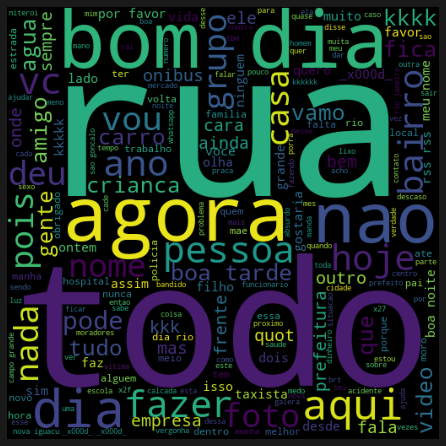

In [358]:
#Word cloud todas as palavras
big_text_cloud = WordCloud(width = 512, height = 512).generate(big_text)

plt.figure(figsize = (7,6), facecolor = 'k')
plt.imshow(big_text_cloud)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

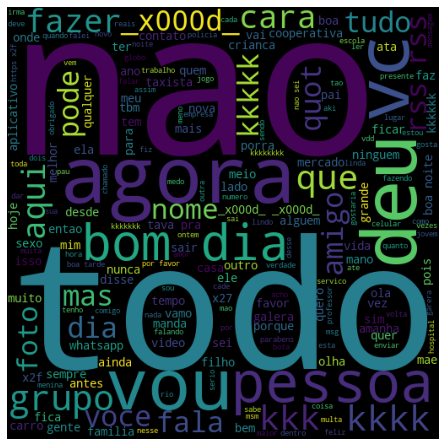

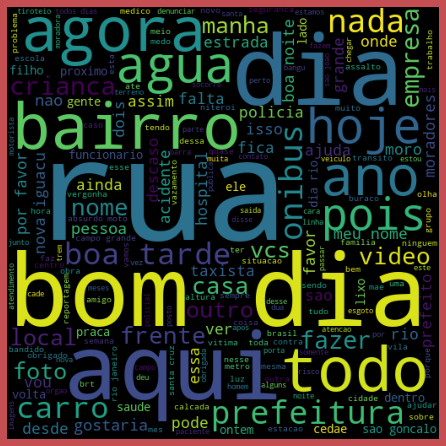

In [327]:


#True messages

no_spam_words = ' '.join(list(df[df['SPAM'] == True ]['text_norm']))
no_spam = WordCloud(width = 512, height = 512).generate(no_spam_words)

plt.figure(figsize = (7,6), facecolor = 'w')
plt.imshow(no_spam)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()


#Spam messages

spam_words = ' '.join(list(df[df['SPAM'] == False ]['text_norm']))
spam_wc = WordCloud(width = 512, height = 512).generate(spam_words)

plt.figure(figsize = (7,6), facecolor = 'r')
plt.imshow(spam_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()
#obs: colocar as wordclouds lado a lado

In [331]:
#def woc(data,bgcolor):
    #plt.figure(figsize=(10,10))
    #wc=WordCloud(background_color=bgcolor,max_words=100).generate(" ".join(data))
    # We will merge the data as it is row by row
    #plt.imshow(wc)
    #plt.axis("off") # Erases the edge of pictures

## Tokenization

In [334]:
#function to apply tokenization
def tokenize(text):
    tokens = re.split("\W+", text)# W+ means all capital, small alphabets and integers 0-9
    return tokens

df["text_tokenized"] = df["text_norm"].apply(lambda x: tokenize(x))

df.head()

,ID,Message,SPAM,Spam,text_norm,text_tokenized
0,615317,Linda msg!,True,1,linda msg,"[linda, msg]"
1,855344,To fazendo batida de kwui com coco,True,1,fazendo batida kwui coco,"[fazendo, batida, kwui, coco]"
2,1007222,Esse dinheiro só vai sair para quem está com o...,True,1,esse dinheiro sair nome lista esse dinheiro sa...,"[esse, dinheiro, sair, nome, lista, esse, dinh..."
3,811063,Isso msm Irmã.. nao lembrava dos nomes kkk,True,1,isso msm irma lembrava nomes kkk,"[isso, msm, irma, lembrava, nomes, kkk]"
4,913944,Ai xara eu sujiro esse,True,1,xara sujiro,"[xara, sujiro]"


## Removing Stopwords

In [335]:
##Feito na funcão normaliza texto

## Lemmatizer

Na lemmatization também vamos buscar reduzir a palavra à sua raiz, retirando todas as inflexões e chegando ao lemma. Porém, essa redução sempre resultará em uma palavra que realmente existe na gramática. Outro ponto importante é que, nessa técnica, a classe gramatical da palavra será levada em consideração para fazer a redução. Vamos agora utilizar a biblioteca spaCy para aplicar essa técnica.

In [336]:
wn = nltk.WordNetLemmatizer()

def lemmatizer(t_text):
    text = [wn.lemmatize(word) for word in t_text]
    return text

df["text_lemmatized"] = df["text_tokenized"].apply(lambda x: lemmatizer(x))
df.head()

,ID,Message,SPAM,Spam,text_norm,text_tokenized,text_lemmatized
0,615317,Linda msg!,True,1,linda msg,"[linda, msg]","[linda, msg]"
1,855344,To fazendo batida de kwui com coco,True,1,fazendo batida kwui coco,"[fazendo, batida, kwui, coco]","[fazendo, batida, kwui, coco]"
2,1007222,Esse dinheiro só vai sair para quem está com o...,True,1,esse dinheiro sair nome lista esse dinheiro sa...,"[esse, dinheiro, sair, nome, lista, esse, dinh...","[esse, dinheiro, sair, nome, lista, esse, dinh..."
3,811063,Isso msm Irmã.. nao lembrava dos nomes kkk,True,1,isso msm irma lembrava nomes kkk,"[isso, msm, irma, lembrava, nomes, kkk]","[isso, msm, irma, lembrava, nome, kkk]"
4,913944,Ai xara eu sujiro esse,True,1,xara sujiro,"[xara, sujiro]","[xara, sujiro]"


## Message length and % of ponctuation
Explore distribution of text length

In [337]:
# Function to calculate length of message excluding space
df['Message_len'] = df['Message'].apply(lambda x: len(x) - x.count(" "))

df.head()

def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")), 3)*100

df['punct%'] = df['Message'].apply(lambda x: count_punct(x))

df.head()

,ID,Message,SPAM,Spam,text_norm,text_tokenized,text_lemmatized,Message_len,punct%
0,615317,Linda msg!,True,1,linda msg,"[linda, msg]","[linda, msg]",9,11.1
1,855344,To fazendo batida de kwui com coco,True,1,fazendo batida kwui coco,"[fazendo, batida, kwui, coco]","[fazendo, batida, kwui, coco]",28,0.0
2,1007222,Esse dinheiro só vai sair para quem está com o...,True,1,esse dinheiro sair nome lista esse dinheiro sa...,"[esse, dinheiro, sair, nome, lista, esse, dinh...","[esse, dinheiro, sair, nome, lista, esse, dinh...",113,7.1
3,811063,Isso msm Irmã.. nao lembrava dos nomes kkk,True,1,isso msm irma lembrava nomes kkk,"[isso, msm, irma, lembrava, nomes, kkk]","[isso, msm, irma, lembrava, nome, kkk]",35,5.7
4,913944,Ai xara eu sujiro esse,True,1,xara sujiro,"[xara, sujiro]","[xara, sujiro]",18,0.0


In [338]:
df['SPAM'].value_counts()

True     932
False    841
Name: SPAM, dtype: int64

### Avaliando distribuição dos tamanhos das palavras e presença de pontuação em Spam e não Spam

In [339]:
df.groupby('SPAM')['Message_len'].sum()

SPAM
False    135142
True     136054
Name: Message_len, dtype: int64

In [341]:
#avarage message punctuation
df.groupby('SPAM')['punct%'].sum()

SPAM
False    2353.9
True     2813.7
Name: punct%, dtype: float64

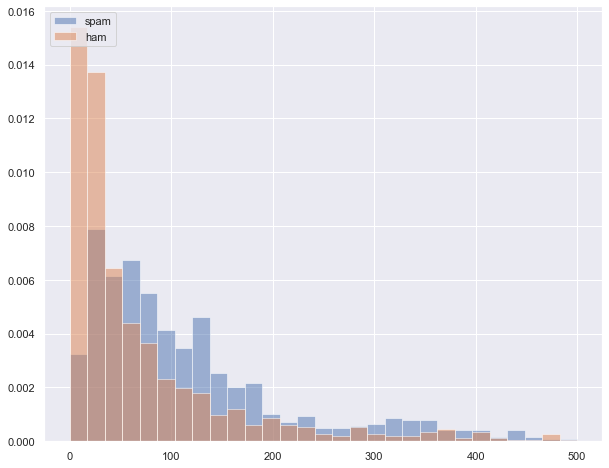

In [384]:
#Setting the size and grid for plotting
sns.set(rc= {"figure.figsize": (10, 8)})

bins = np.linspace(0, 500, 30)

plt.hist(df[df['Spam']==0]['Message_len'], bins, alpha=0.5, density=True, label='spam')
plt.hist(df[df['Spam']==1]['Message_len'], bins, alpha=0.5, density=True, label='ham')
plt.legend(loc='upper left')
plt.show()

#data.length[(data['class'] == 'spam')

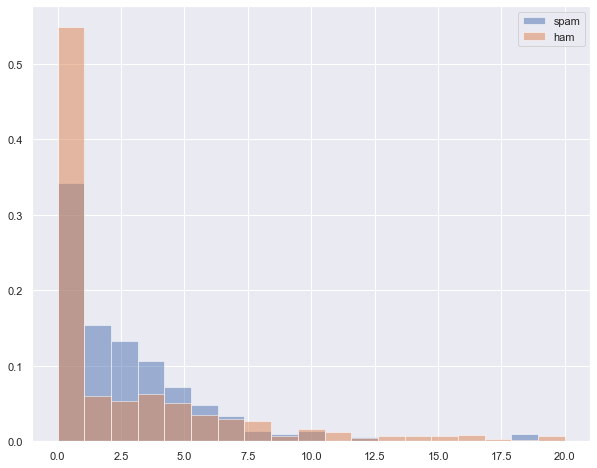

In [385]:
sns.set(rc= {"figure.figsize": (10, 8)})

bins = np.linspace(0, 20, 20)

plt.hist(df[df['Spam']==0]['punct%'], bins, alpha=0.5, density=True, label='spam')
plt.hist(df[df['Spam']==1]['punct%'], bins, alpha=0.5, density=True, label='ham')
plt.legend(loc='upper right')
plt.show()

### Analisando as palavras mais frequentes para Spam e não Spam

In [392]:
#for counting frequently occurence of spam and ham. Melhorar aqui

count1 = Counter(" ".join(df[df['Spam']==1]["text_norm"]).split()).most_common(30)
data1 = pd.DataFrame.from_dict(count1)
data1 = data1.rename(columns={0: "words of ham", 1 : "count"})
count2 = Counter(" ".join(df[df['Spam']==0]["text_norm"]).split()).most_common(30)
data2 = pd.DataFrame.from_dict(count2)
data2 = data2.rename(columns={0: "words of spam", 1 : "count_"})

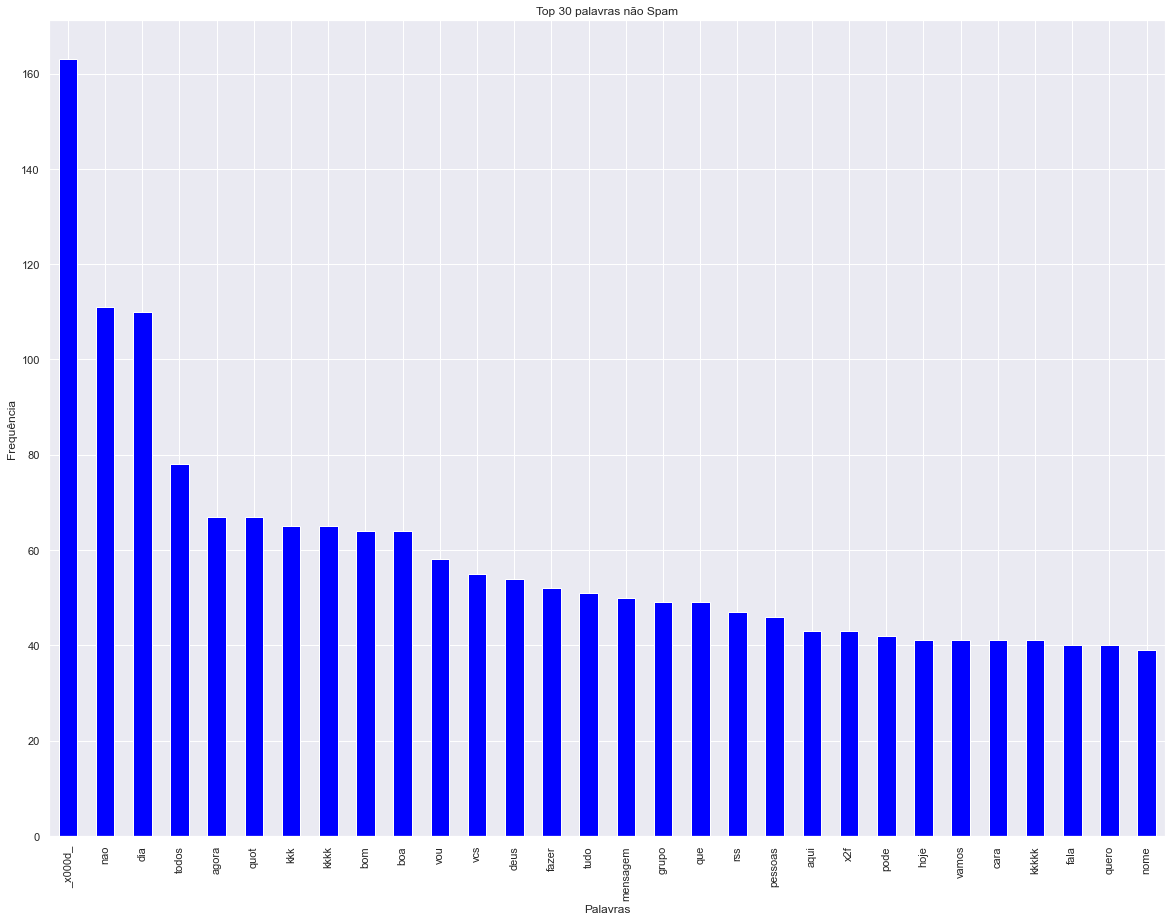

In [395]:
data1.plot.bar(legend = False, color = 'blue',figsize = (20,15))
y_pos = np.arange(len(data1["words of ham"]))
plt.xticks(y_pos, data1["words of ham"])
plt.title('Top 30 palavras não Spam')
plt.xlabel('Palavras')
plt.ylabel('Frequência')
plt.show()

#_xd000_ é um erro gerado por emoticons? deveria tirar? ou ele funcionaria como um classificador de emoticons na conversa,
#aumentando a precisão dos modelos?

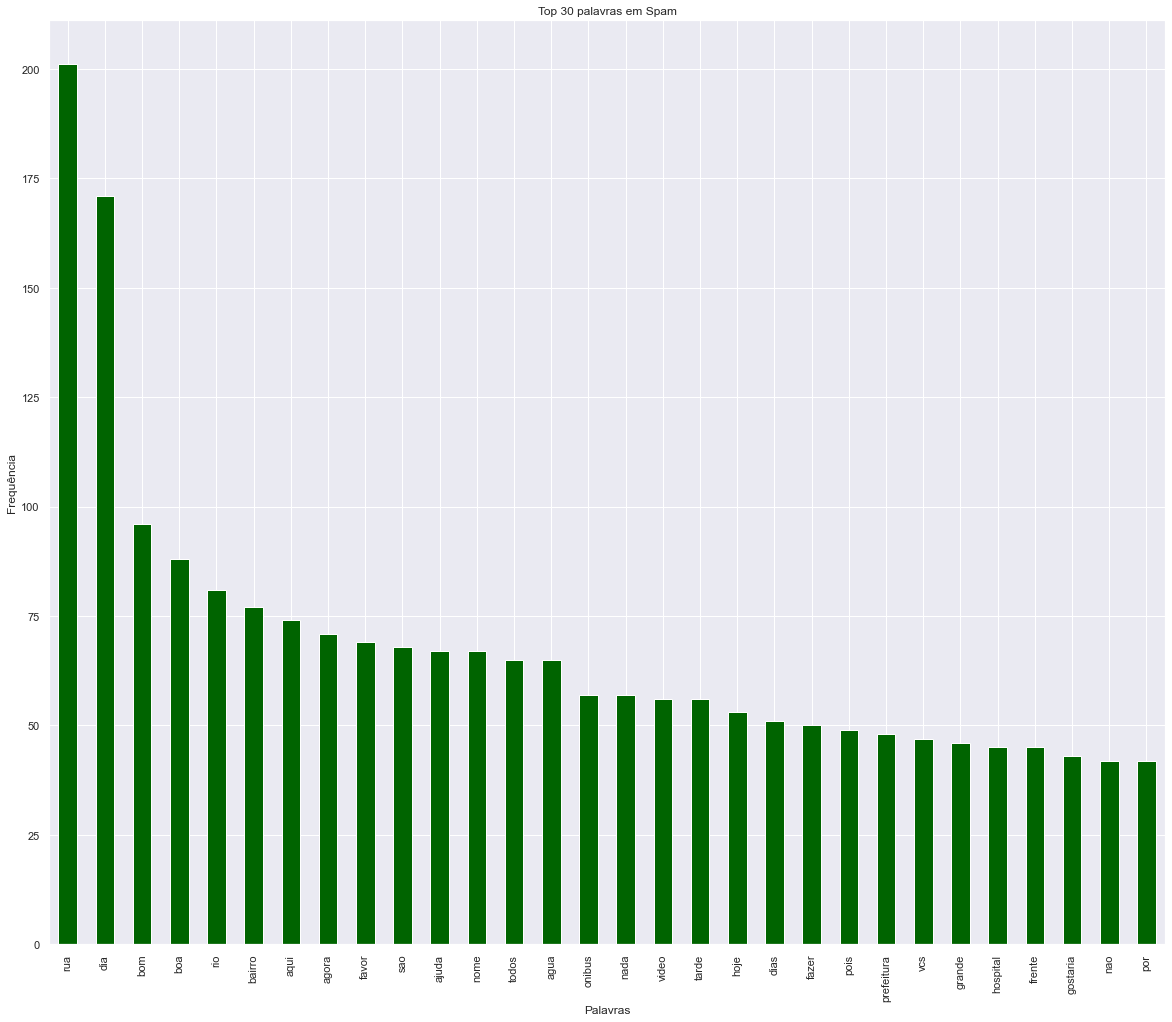

In [438]:
data2.plot.bar(legend = False, color = 'darkgreen', figsize = (20,17))
y_pos = np.arange(len(data2["words of spam"]))
plt.xticks(y_pos, data2["words of spam"])
plt.title('Top 30 palavras em Spam')
plt.xlabel('Palavras')
plt.ylabel('Frequência')
plt.show()

## Vectorization - Bag of Words
primeiro tem que criar um CountVectorizer para contar o número de palavras (frequência do termo), 
limitar o tamanho do seu vocabulário, aplicar palavras de parada e etc...

## Vectorization - BAG OF WORDS
Need to convert each of those messages(lemmas) into a vector the SciKit Learn's algorithm models can work with using bag-of-words model.

### STEP:

Count how many times does a word occur in each message (Known as term frequency) by CountVectorizer.

Weigh the counts, so that frequent tokens get lower weight (inverse document frequency)

Normalize the vectors to unit length, to abstract from the original text length (L2 norm) by TF-IDF, using scikit-learn's TfidfTransformer.

CountVectorizer : will convert a collection of text documents to a matrix of token counts in 2D matrix:

1-dimension is the entire vocabulary (1 row per word) other dimension are the actual documents, in this case a column per text

In [440]:
cv = CountVectorizer()#analizer = função pra limpar o texto
word_count_vector = cv.fit_transform(df['text_norm'])

In [349]:
#aqui as colunas reprensentam palavras únicas (9411)
word_count_vector.shape

(1773, 9411)

## Apply TFIDF 
Encoding Text as integer i.e. numeric form to create feature vectors so that we can apply ML algos on it.

In [407]:
feature_extraction = TfidfVectorizer(min_df=1, lowercase = 'True')
# min_df = se uma pavara não repetir, ou repetir apenas uma vez, ela não é importante para análises predivitas

In [ ]:
X_tfidf = feature_extraction.fit_transform(df['text_norm'])
print(X_tfidf.shape)
print(feature_extraction.get_feature_names())

## Modeling

In [398]:
import pandas as pd
import re
import string
import nltk

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier


In [452]:
X=df[['Message', 'Message_len', 'punct%']]
y=df['SPAM']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42, stratify=y)

In [453]:
#feature_extraction = TfidfVectorizer(min_df=1, lowercase = 'True')

feature_extraction_fit = feature_extraction.fit(X_train['Message']) #Message ou Message

tfidf_train = feature_extraction_fit.transform(X_train['Message'])
tfidf_test = feature_extraction_fit.transform(X_test['Message'])

X_train_vect = pd.concat([X_train[['Message_len', 'punct%']].reset_index(drop=True), 
           pd.DataFrame(tfidf_train.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['Message_len', 'punct%']].reset_index(drop=True), 
           pd.DataFrame(tfidf_test.toarray())], axis=1)

X_train_vect.head()

,Message_len,punct%,0,1,2,3,4,5,6,7,...,7757,7758,7759,7760,7761,7762,7763,7764,7765,7766
0,100,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,41,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,107,9.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,294,3.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.159563,0.0,0.0,0.0


In [454]:
lr = LogisticRegression()
nb = MultinomialNB()
knc = KNeighborsClassifier()
svc = SVC(gamma = 'auto')
dtc = DecisionTreeClassifier()
rfc = RandomForestClassifier(n_estimators=100)
gbc = GradientBoostingClassifier()
abc = AdaBoostClassifier()



models = {'Logistic Regression':lr, 'Naive Bayes classifier':nb, 'k-nearest neighbors':knc, 
          'Support Vector Machine':svc, 'Decision Tree Classifier':dtc, 
          'Random Forest Classifier':rfc, 'Gradient Boosting Classifier':gbc, 'AdaBoost Classifier':abc}

In [455]:
def eval_model(model):
    
    model.fit(X_train_vect, y_train)
    y_pred = model.predict(X_test_vect)
    
    test_accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred), columns=['ham', 'spam'], index=['ham','spam'])
    
    return test_accuracy, conf_matrix

In [493]:
test_accuracies = []

for name, model in models.items():
    test_acc, conf_matrix = eval_model(model) 
    test_accuracies.append(test_acc)
    print(f'{name} ---> Test accuracy - {test_acc*100:.2f}%')

Logistic Regression ---> Test accuracy - 83.83%
Naive Bayes classifier ---> Test accuracy - 79.70%
k-nearest neighbors ---> Test accuracy - 61.65%
Support Vector Machine ---> Test accuracy - 66.17%
Decision Tree Classifier ---> Test accuracy - 70.86%
Random Forest Classifier ---> Test accuracy - 80.64%
Gradient Boosting Classifier ---> Test accuracy - 78.76%
AdaBoost Classifier ---> Test accuracy - 80.26%


In [482]:
lr_model = lr.fit(X_train_vect, y_train)

y_pred = lr_model.predict(X_test_vect)

precision, recall, fscore, train_support = score(y_test, y_pred, pos_label=False, average='binary')
print('Precision: {} / Recall: {} / F1-Score: {}'.format(
round(precision, 3), round(recall, 3), round(fscore,3)))

Precision: 0.835 / Recall: 0.821 / F1-Score: 0.828


In [483]:
lr_model = lr.fit(X_train_vect, y_train)

y_pred = lr_model.predict(X_test_vect)

precision, recall, fscore, train_support = score(y_test, y_pred, pos_label=True, average='binary')
print('Precision: {} / Recall: {} / F1-Score: {}'.format(
round(precision, 3), round(recall, 3), round(fscore,3)))

Precision: 0.842 / Recall: 0.854 / F1-Score: 0.848


In [491]:
#tentar criar um laço para fornecer Precision, Recall e 1=F1-Score para os modelos

test_accuracies = []

for name, model in models.items():
    test_acc, conf_matrix = eval_model(model) 
    test_accuracies.append(precision)
    lr_model = lr.fit(X_train_vect, y_train)
    y_pred = lr_model.predict(X_test_vect)
    precision, recall, fscore, train_support = score(y_test, y_pred, pos_label=True, average='binary')
    print('Precision: {} / Recall: {} / F1-Score: {}'.format(
round(precision, 3), round(recall, 3), round(fscore,3)))

Precision: 0.842 / Recall: 0.854 / F1-Score: 0.848
Precision: 0.842 / Recall: 0.854 / F1-Score: 0.848
Precision: 0.842 / Recall: 0.854 / F1-Score: 0.848
Precision: 0.842 / Recall: 0.854 / F1-Score: 0.848
Precision: 0.842 / Recall: 0.854 / F1-Score: 0.848
Precision: 0.842 / Recall: 0.854 / F1-Score: 0.848
Precision: 0.842 / Recall: 0.854 / F1-Score: 0.848
Precision: 0.842 / Recall: 0.854 / F1-Score: 0.848
